In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import multi_dot

from scipy.stats import norm
from tabulate import tabulate

import matplotlib.pyplot as plt

In [6]:
# Load data
import yfinance as yf
stocks = ['AAPL', 'AMZN', 'META', 'GOOG', 'NFLX']
df = yf.download(stocks, start='2013-01-01', progress=False)['Adj Close']
df.index = pd.to_datetime(df.index)

# Check first 5 values
df.head()

,AAPL,AMZN,GOOG,META,NFLX
Date,,,,,
2013-01-02,16.791189,12.8655,18.013729,28.000000,13.144286
2013-01-03,16.579243,12.9240,18.024191,27.770000,13.798571
2013-01-04,16.117435,12.9575,18.380356,28.760000,13.711429
2013-01-07,16.022625,13.4230,18.300158,29.420000,14.171429
2013-01-08,16.065750,13.3190,18.264042,29.059999,13.880000


In [7]:
# Calculate daily return
returns = df.pct_change().dropna()

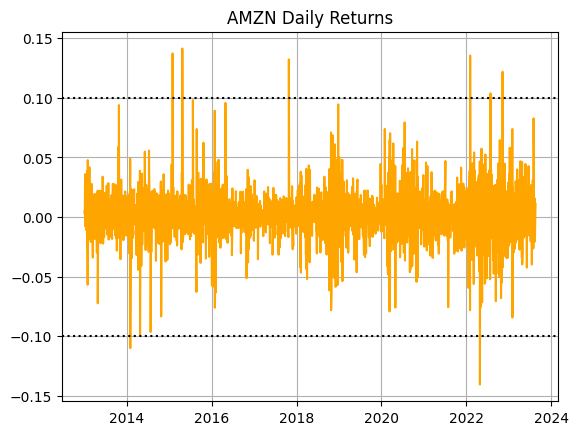

In [8]:
# Visualize AMZN daily returns
plt.plot(returns['AMZN'], color='orange')
plt.axhline(y=0.10, ls='dotted', color='black')
plt.axhline(y=-0.10, ls='dotted', color='black')
plt.title('AMZN Daily Returns')
plt.grid(True)

In [9]:
# Calculate mean and standard deviation
mean = np.mean(returns['AMZN'])
stdev = np.std(returns['AMZN'])

# Calculate VaR at difference confidence level
VaR_90 = norm.ppf(1-0.90, mean, stdev)
VaR_95 = norm.ppf(1-0.95, mean, stdev)
VaR_99 = norm.ppf(1-0.99, mean, stdev)

In [10]:
# Output results in tabular format
table = [['90%', VaR_90], ['95%', VaR_95], ['99%', VaR_99]]
header = ['Confidence Level', 'Value at Risk']
print(tabulate(table, headers=header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0253502
95%                      -0.0328457
99%                      -0.046906


In [11]:
# VaR function
def VaR(symbol, cl=0.95):
    mean = np.mean(returns[symbol])
    stdev = np.std(returns[symbol])
    
    return np.around(100*norm.ppf(1-cl, mean, stdev), 4)

In [12]:
# VaR for stocks
print('VaR for FAANG Stocks')
print('---'*11)
[print(f'VaR at 95% CL for {stock:4}: {VaR(stock)}%') for stock in df.columns][0]

VaR for FAANG Stocks
---------------------------------
VaR at 95% CL for AAPL: -2.8641%
VaR at 95% CL for AMZN: -3.2846%
VaR at 95% CL for GOOG: -2.7552%
VaR at 95% CL for META: -3.8859%
VaR at 95% CL for NFLX: -4.7179%


In [13]:
num_of_shares = 1000
price = df['AMZN'].iloc[-1]
position = num_of_shares * price

amzn_var = position * VaR_99

print(f'Amazon Holding Value: {position}')
print(f'Amazon VaR at 99% confidence level is: {amzn_var}')

Amazon Holding Value: 134679.99267578125
Amazon VaR at 99% confidence level is: -6317.303170028251


In [14]:
# VaR calculation by applying direct formulae
position * (mean + norm.ppf(1-0.99) * stdev)

-6317.303170028251

In [15]:
forecast_days = 5
f_VaR_90 = VaR_90 * np.sqrt(forecast_days)
f_VaR_95 = VaR_95 * np.sqrt(forecast_days)
f_VaR_99 = VaR_99 * np.sqrt(forecast_days)

In [16]:
# Output results in tabular format
ftable = [['90%', f_VaR_90], ['95%', f_VaR_95], ['99%', f_VaR_99]]
fheader = ['Confidence Level', '5-Day Forecast Value at Risk']
print(tabulate(ftable, headers=fheader))

Confidence Level      5-Day Forecast Value at Risk
------------------  ------------------------------
90%                                     -0.0566849
95%                                     -0.0734453
99%                                     -0.104885


In [19]:
amzn_var_5days = position * f_VaR_99
print(f'Amazon Holding Value: {position}')
print(f'Amazon VaR at 99% confidence level is: {amzn_var_5days}')

Amazon Holding Value: 134679.99267578125
Amazon VaR at 99% confidence level is: -14125.919322658081


Text(0.5, 1.0, 'VaR_95 Scaled by Time')

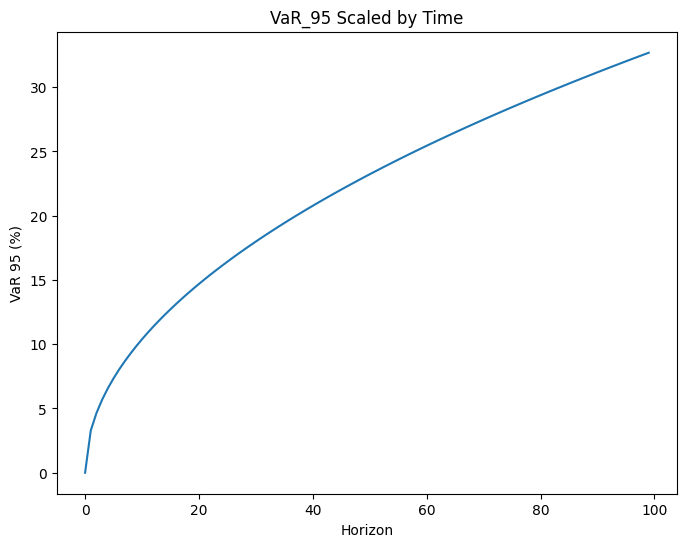

In [20]:
# Scaled VaR over different time horizon
plt.figure(figsize=(8,6))
plt.plot(range(100), [-100*VaR_95*np.sqrt(x) for x in range(100)])
plt.xlabel('Horizon')
plt.ylabel('VaR 95 (%)')
plt.title('VaR_95 Scaled by Time')

In [21]:
# Use quantile function for Historical VaR
hVaR_90 = returns['AMZN'].quantile(0.10) 
hVaR_95 = returns['AMZN'].quantile(0.05) 
hVaR_99 = returns['AMZN'].quantile(0.01) 

In [22]:
htable = [['90%', hVaR_90], ['95%', hVaR_95], ['99%', hVaR_99]]
print(tabulate(htable, headers=header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.0206985
95%                      -0.0305339
99%                      -0.056899


In [24]:
# Calculate CVaR
CVaR_90 = returns['AMZN'][returns['AMZN'] <= hVaR_90].mean()
CVaR_95 = returns['AMZN'][returns['AMZN'] <= hVaR_95].mean()
CVaR_99 = returns['AMZN'][returns['AMZN'] <= hVaR_99].mean()

In [25]:
ctable = [['90%', CVaR_90], ['95%', CVaR_95], ['99%', CVaR_99]]
cheader = ['Confidence Level', 'Conditional Value at Risk']
print(tabulate(ctable, headers=cheader))

Confidence Level      Conditional Value at Risk
------------------  ---------------------------
90%                                  -0.0358763
95%                                  -0.0468536
99%                                  -0.0754279


In [27]:
# Set seed for reproducibility
np.random.seed(12345)

# Number of simulations
n_sims = 5000

# Simulate returns and sort
sim_returns = np.random.normal(mean, stdev, n_sims)

# Use percentile function for MCVaR
MCVaR_90 = np.percentile(sim_returns, 10) 
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns, 1)

In [28]:
mctable = [['90%', MCVaR_90], ['95%', MCVaR_95], ['99%', MCVaR_99]]
print(tabulate(mctable, headers=header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.025029
95%                      -0.0324939
99%                      -0.0458791


In [30]:
wts = np.array([0.2, 0.2, 0.2, 0.2, 0.2])[:np.newaxis]
wts

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [31]:
port_ret = np.dot(returns, wts)
port_ret.flatten()

array([ 0.00681362,  0.00476653,  0.01643532, ..., -0.01467963,
       -0.00470542,  0.01157379])

In [32]:
port_mean = port_ret.mean()
port_mean

0.0011820624649242896

In [33]:
# Covariance matrix
returns.cov()

,AAPL,AMZN,GOOG,META,NFLX
AAPL,0.000326,0.000186,0.000177,0.000211,0.000172
AMZN,0.000186,0.000426,0.000224,0.000273,0.000292
GOOG,0.000177,0.000224,0.000299,0.000251,0.000220
META,0.000211,0.000273,0.000251,0.000592,0.000295
NFLX,0.000172,0.000292,0.000220,0.000295,0.000884


In [34]:
# Portfolio volatility
port_stdev = np.sqrt(multi_dot([wts.T, returns.cov(), wts]))
port_stdev.flatten()[0]

0.016885067759651134

In [35]:
# Portfolio position
port_pos = (df.iloc[-1] * num_of_shares).sum()
port_pos

1137639.9841308594

In [36]:
# Calculate portfolio VaR at difference confidence level
pVaR_90 = norm.ppf(1-0.90, port_mean, port_stdev).flatten()[0]
pVaR_95 = norm.ppf(1-0.95, port_mean, port_stdev).flatten()[0]
pVaR_99 = norm.ppf(1-0.99, port_mean, port_stdev).flatten()[0]

In [37]:
pVaR_95

-0.026591402480859245

In [38]:
# Output results in tabular format 
ptable = [['90%', pVaR_90], ['95%', pVaR_95], ['99%', pVaR_99]]
print(tabulate(ptable, headers=header))

Confidence Level      Value at Risk
------------------  ---------------
90%                      -0.020457
95%                      -0.0265914
99%                      -0.0380985


In [40]:
# Iterate over symbols
for stock in df.columns:
    pos = df[stock].iloc[-1] * num_of_shares
    pvar = pos * VaR(stock)
    
    print(f'{stock} Holding Value: {pos:0.4}')
    print(f'{stock} VaR at 95% confidence level: {pvar:0.4}')
    print()
    
print(f'Portfolio Holding Value: {port_pos:0.4}')
print(f'Portfolio VaR at 95% confidence level: {port_pos * pVaR_95:0.4}')

AAPL Holding Value: 1.758e+05
AAPL VaR at 95% confidence level: -5.036e+05

AMZN Holding Value: 1.347e+05
AMZN VaR at 95% confidence level: -4.424e+05

GOOG Holding Value: 1.289e+05
GOOG VaR at 95% confidence level: -3.552e+05

META Holding Value: 2.899e+05
META VaR at 95% confidence level: -1.127e+06

NFLX Holding Value: 4.083e+05
NFLX VaR at 95% confidence level: -1.926e+06

Portfolio Holding Value: 1.138e+06
Portfolio VaR at 95% confidence level: -3.025e+04
